# Labo 5

In [1]:
%pip install tf_keras_vis tflite-support-nightly

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\cfont\.virtualenvs\pythonProject\Scripts\python.exe -m pip install --upgrade pip' command.


## Database creation

In [107]:
import os
import pandas as pd
from glob import glob

def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])

    return pd.DataFrame(data, columns = ["path", "label"])

In [108]:
train_df = create_dataframe_from_directories(os.path.join(".","data"))

In [109]:
LABEL_NAMES = pd.unique(train_df['label'])
LABEL_NAMES

array(['bus', 'cars', 'vans'], dtype=object)

TypeError: 'Text' object is not callable

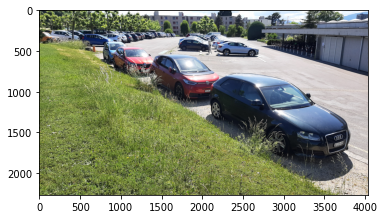

In [55]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image

plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in train_df.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(PIL.Image.open(rowdata.path))
    ax.title(rowdata.label)
    plt.axis("off")
    i += 1

# Dataset exploration

In [48]:
df_counts = train_df.groupby(["label"])["label"].count()
df_counts

label
bus     13
cars    64
vans    36
Name: label, dtype: int64

label
bus     AxesSubplot(0.125,0.125;0.775x0.755)
cars    AxesSubplot(0.125,0.125;0.775x0.755)
vans    AxesSubplot(0.125,0.125;0.775x0.755)
Name: label, dtype: object

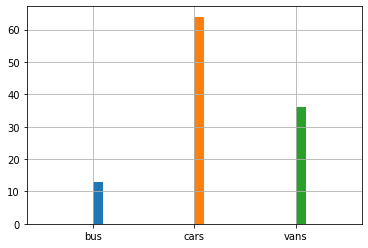

In [53]:
(train_df.groupby(["label"])["label"]).hist()

# Preprocessing steps

In [136]:
from tensorflow.keras.layers import (
    Resizing, Rescaling, RandomFlip, RandomRotation
)

from tensorflow.keras import Sequential

import numpy as np

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation
])

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))

    return opened_img

def augment_image(image):
    return image_augmentations(image)


train_df["path"].map(lambda x: print(x))

.\data\bus\20220525_162701(0).jpg
.\data\bus\20220525_162701.jpg
.\data\bus\20220525_162702(0).jpg
.\data\bus\20220525_162702(1).jpg
.\data\bus\20220525_162702.jpg
.\data\bus\20220525_162705.jpg
.\data\bus\20220525_162706.jpg
.\data\bus\20220525_162707(0).jpg
.\data\bus\20220525_162707.jpg
.\data\bus\20220525_162709.jpg
.\data\bus\20220525_162710.jpg
.\data\bus\20220525_163113.jpg
.\data\bus\20220525_163114.jpg
.\data\cars\20220525_160720.jpg
.\data\cars\20220525_160937.jpg
.\data\cars\20220525_160939.jpg
.\data\cars\20220525_160940.jpg
.\data\cars\20220525_160943.jpg
.\data\cars\20220525_160958.jpg
.\data\cars\20220525_161015.jpg
.\data\cars\20220525_161019.jpg
.\data\cars\20220525_161022.jpg
.\data\cars\20220525_161023.jpg
.\data\cars\20220525_161025.jpg
.\data\cars\20220525_161036.jpg
.\data\cars\20220525_161039.jpg
.\data\cars\20220525_161041.jpg
.\data\cars\20220525_161043.jpg
.\data\cars\20220525_161046.jpg
.\data\cars\20220525_161050.jpg
.\data\cars\20220525_161052.jpg
.\data\ca

0      None
1      None
2      None
3      None
4      None
       ... 
282    None
283    None
284    None
285    None
286    None
Name: path, Length: 287, dtype: object

In [141]:
def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))

    return opened_img

def augment_images(images):
    return np.stack([
        image_augmentations(img) for img in images
    ])

train_df['image'] = train_df.apply(lambda row: augment_image(open_image(row["path"])), axis=1)

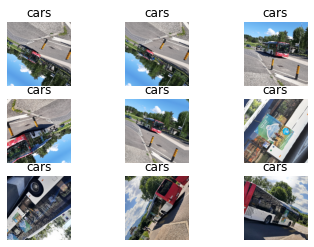

In [146]:
i = 0
for image in train_df.head(9)["image"]:
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

## Define model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout
)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )

    layers = base_model.output

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on
        GlobalAveragePooling2D(),
        # TODO: ...
    ]

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    # TODO: freeze layers

    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )

    return model